In [7]:
import matplotlib.pyplot as plt
import numpy as np
import umap

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights

Device used: cuda

--- Version 1 : scratch ---
Computing UMAP for Scratch (initial state)


c:\Users\prete\miniconda3\envs\mach-learn\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


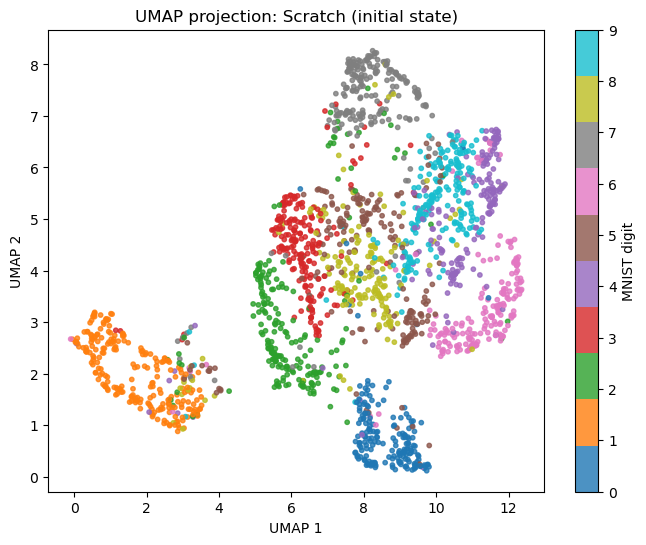

Starting training for 3 epochs
Epoch 1: loss = 0.1161, accuracy = 0.9654
Epoch 2: loss = 0.0533, accuracy = 0.9848
Epoch 3: loss = 0.0410, accuracy = 0.9876
Computing UMAP for Scratch (final state)


c:\Users\prete\miniconda3\envs\mach-learn\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


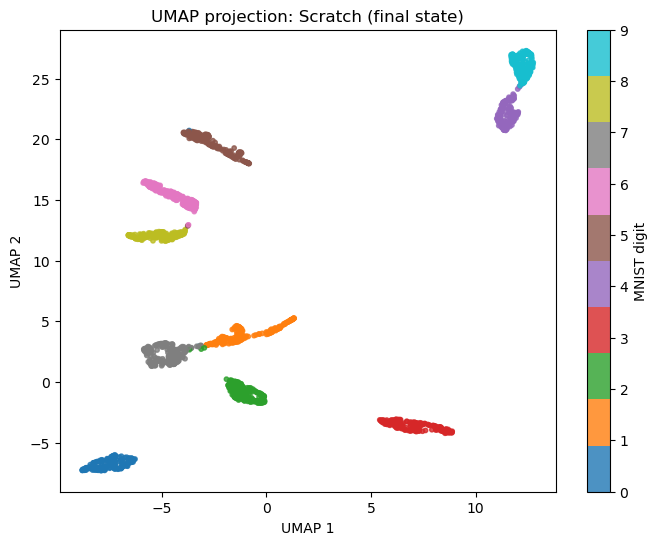


--- Version 2 : pretrained ---
Computing UMAP for Pretrained (initial state)


c:\Users\prete\miniconda3\envs\mach-learn\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


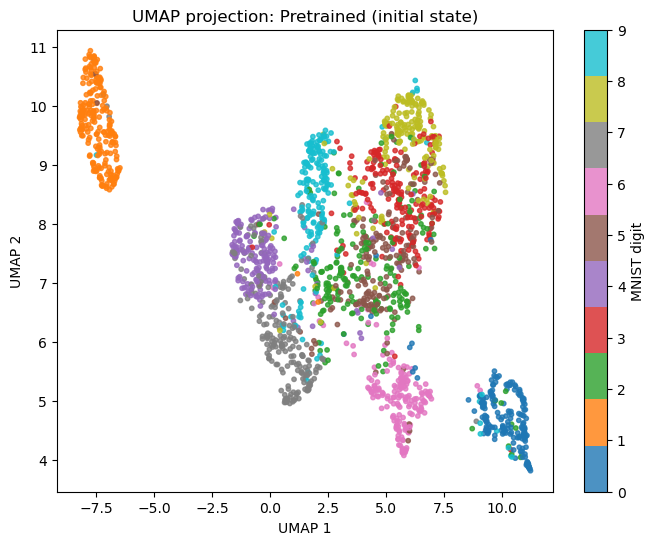

Starting training for 3 epochs
Epoch 1: loss = 0.1045, accuracy = 0.9704
Epoch 2: loss = 0.0485, accuracy = 0.9869
Epoch 3: loss = 0.0367, accuracy = 0.9896
Computing UMAP for Pretrained (final state)


c:\Users\prete\miniconda3\envs\mach-learn\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


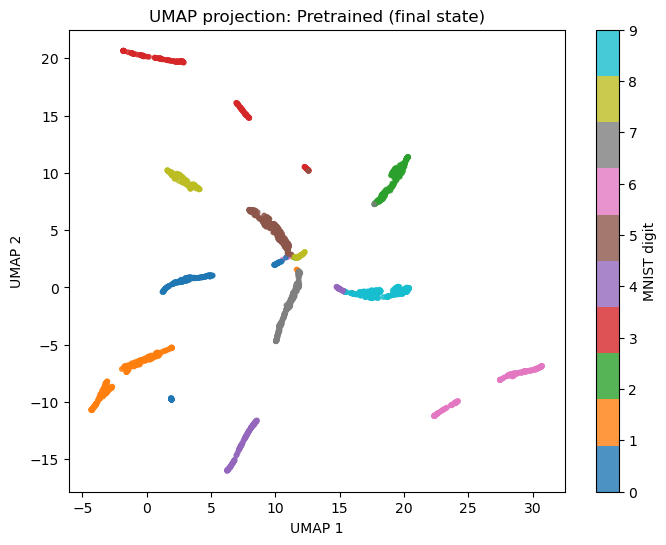


Performance analysis


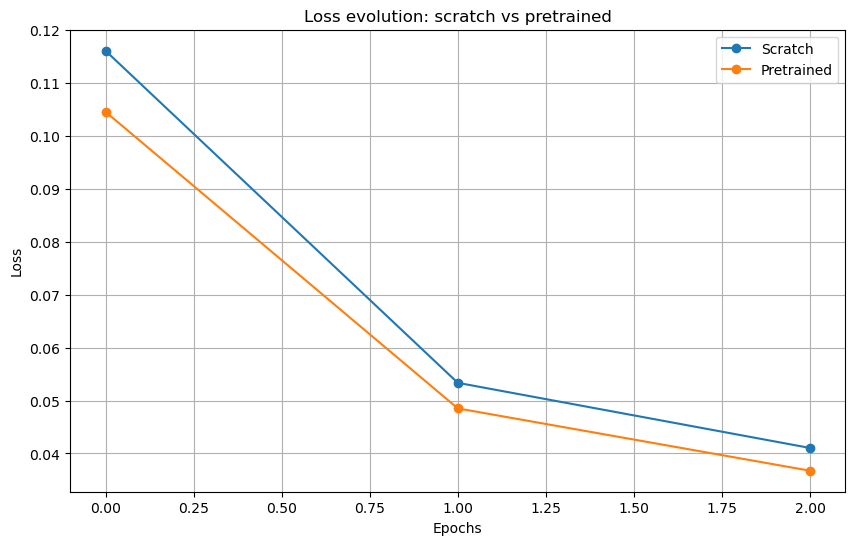

C:\Users\prete\AppData\Local\Temp\ipykernel_24760\831634531.py:216: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
C:\Users\prete\AppData\Local\Temp\ipykernel_24760\831634531.py:223: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


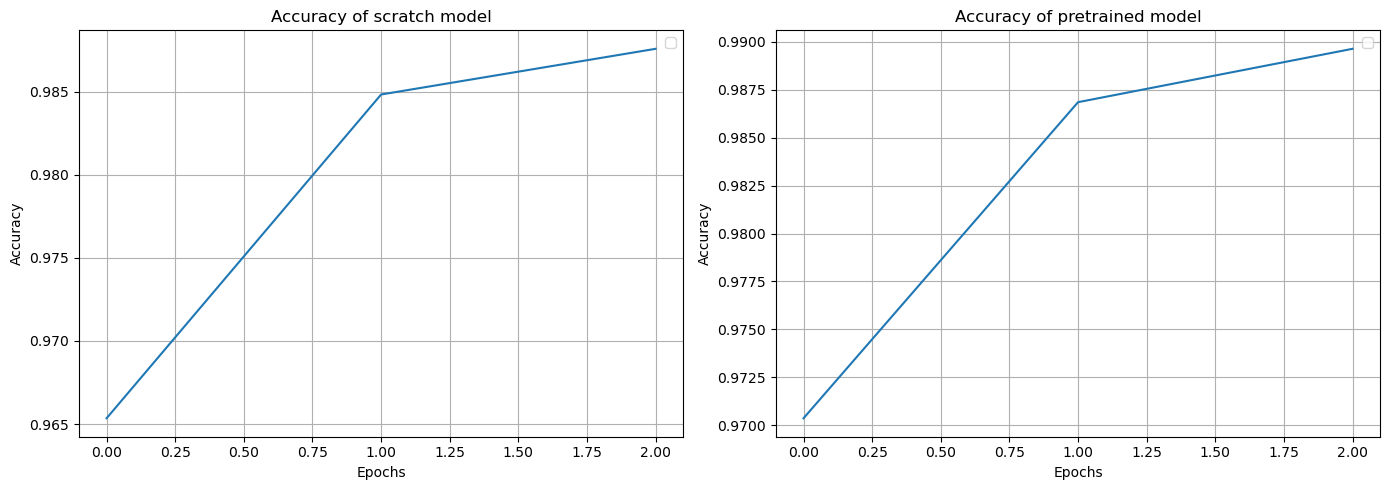

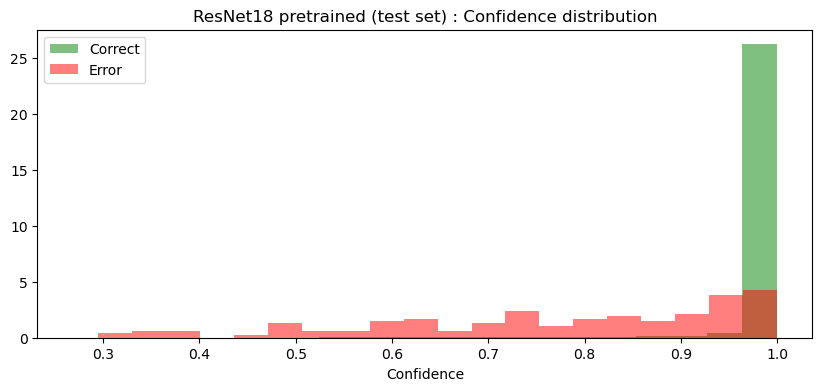

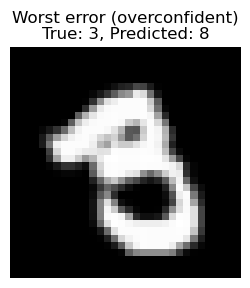

In [ ]:
# ========================================
# Configuration and data loading
# ========================================

batchSize = 128
numEpochs = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device used: {device}")

# Transformation: MNIST (1 channel) -> ResNet (3 channels)
# We also resize to 32x32 because 28x28 is very small for a standard ResNet
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loading datasets
trainDataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testDataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
testLoader = torch.utils.data.DataLoader(testDataset, batch_size=batchSize, shuffle=False)

# Fixed subset for UMAP visualization
indices = np.random.choice(len(testDataset), 2000, replace=False) # 2000 samples for speed
subsetImages = torch.stack([testDataset[i][0] for i in indices]).to(device)
subsetLabels = np.array([testDataset[i][1] for i in indices])

# ==========================================
# Reused (and adapted) functions from previous hands-on
# ==========================================

def makeResNet18(numClasses: int, mode: str = 'full', pretrained: bool = True):
    """ 
    Creates a ResNet18 model adapted for MNIST classification.

    :param numClasses: Number of output classes
    :param mode: 'full' for full fine-tuning, 'last_block' for last block only
    :param pretrained: Whether to use pretrained weights
    """
    if not pretrained:
        model = resnet18(weights=None)  # Random weights for scratch version
    else: 
        model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) # ImageNet weights
    
    # Change final layer
    inFeats = model.fc.in_features
    model.fc = nn.Linear(inFeats, numClasses)
    
    # Layer freezing management
    for param in model.parameters(): param.requires_grad=False
    for param in model.fc.parameters(): param.requires_grad=True
    
    if mode=='last_block':
        for param in model.layer4.parameters(): param.requires_grad=True
    if mode=='full':
        for param in model.parameters(): param.requires_grad=True
        
    return model

def trainAndTrack(model, loader, epochs=3, lr=1e-3):
    """ Adaptation of 'train_model' from previous hands-on that returns loss history and accuracy history. 
    
    :param model: The model to train
    :param loader: DataLoader for training data
    :param epochs: Number of epochs to train
    :param lr: Learning rate
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    lossHistory = []
    accHistory = []
    
    print(f"Starting training for {epochs} epochs")
    
    model.train()
    for ep in range(epochs):
        runningLoss = 0
        runningRight = 0
        totalSamples = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            
            runningLoss += loss.item()

            _, preds = torch.max(logits, 1) # we take the class with highest score
            runningRight += torch.sum(preds == y.data).item() # count correct predictions
            totalSamples += y.size(0)
        
        avgLoss = runningLoss / len(loader)
        epochAcc = runningRight / totalSamples
        lossHistory.append(avgLoss)
        accHistory.append(epochAcc)
        print(f"Epoch {ep+1}: loss = {avgLoss:.4f}, accuracy = {epochAcc:.4f}")
        
    return lossHistory, accHistory

def getFeaturesAndProject(model, images, title):
    """ Extracts features just before flatten and projects with UMAP. 
    
    :param model: The trained model
    :param images: Input images for feature extraction
    :param title: Title for the UMAP plot
    """
    model.eval()
    featureExtractor = nn.Sequential(*list(model.children())[:-1])
    
    with torch.no_grad():
        features = featureExtractor(images) 
        featuresFlat = torch.flatten(features, 1).cpu().numpy()
        
    print(f"Computing UMAP for {title}")
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    embedding = reducer.fit_transform(featuresFlat)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=subsetLabels, cmap='tab10', s=10, alpha=0.8)
    plt.colorbar(scatter, label='MNIST digit')
    plt.title(f"UMAP projection: {title}")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()

# Added function for performance analysis
def analyzePredictions(model, dataset, title="Score analysis"):
    """ Plots the confidence histogram and shows an extreme error case. 
    
    :param model: The trained model
    :param dataset: Dataset to analyze
    :param title: Title for the analysis
    """
    model.eval()
    loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)
    allProbs, allPreds, allTargets, allImages = [], [], [], []
    
    # Collect predictions
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            if isinstance(logits, tuple): 
                logits = logits[0] # to handle tuples
            probs = F.softmax(logits, dim=1)
            allProbs.append(probs.cpu())
            allPreds.append(probs.argmax(dim=1).cpu())
            allTargets.append(y)
            if len(allImages) < 200: 
                allImages.append(x.cpu()) # store images for later display

    probs = torch.cat(allProbs)
    preds = torch.cat(allPreds)
    targets = torch.cat(allTargets)
    images = torch.cat(allImages)
    confidences = probs.max(dim=1).values # confidence is max probability
    correctMask = preds == targets # boolean mask of correct predictions
    
    # Histogram
    plt.figure(figsize=(10, 4))
    plt.hist(confidences[correctMask].numpy(), bins=20, alpha=0.5, color='green', label='Correct', density=True)
    plt.hist(confidences[~correctMask].numpy(), bins=20, alpha=0.5, color='red', label='Error', density=True) # use ~ as NOT operator
    plt.title(f"{title} : Confidence distribution")
    plt.xlabel("Confidence")
    plt.legend()
    plt.show()
    
    # Extreme cases
    wrongIndices = torch.where(~correctMask)[0] # again use ~ for NOT
    if len(wrongIndices) > 0:
        worstIdx = wrongIndices[confidences[wrongIndices].argmax()]
        plt.figure(figsize=(3, 3)); img = images[worstIdx].permute(1, 2, 0).numpy() * 0.5 + 0.5 # denormalize for display
        plt.imshow(img.clip(0, 1), cmap='gray') # clip to avoid out-of-bounds
        plt.axis('off')
        plt.title(f"Worst error (overconfident)\nTrue: {targets[worstIdx]}, Predicted: {preds[worstIdx]}")
        plt.show()

# ========================================
# Comparative evolution
# ========================================

# Scratch version
print("\n--- Version 1 : scratch ---")
modelScratch = makeResNet18(numClasses=10, mode='full', pretrained=False).to(device)
getFeaturesAndProject(modelScratch, subsetImages, "Scratch (initial state)")
lossHistoryScratch, accHistoryScratch = trainAndTrack(modelScratch, trainLoader, epochs=numEpochs, lr=0.001)
getFeaturesAndProject(modelScratch, subsetImages, "Scratch (final state)")

# Pretrained version
print("\n--- Version 2 : pretrained ---")
modelPretrained = makeResNet18(numClasses=10, mode='full', pretrained=True).to(device)
getFeaturesAndProject(modelPretrained, subsetImages, "Pretrained (initial state)")
lossHistoryPretrained, accHistoryPretrained = trainAndTrack(modelPretrained, trainLoader, epochs=numEpochs, lr=0.001)
getFeaturesAndProject(modelPretrained, subsetImages, "Pretrained (final state)")

# ========================================
# Analysis
# ========================================

print('\nPerformance analysis')
plt.figure(figsize=(10, 6))
plt.plot(lossHistoryScratch, label='Scratch', marker='o')
plt.plot(lossHistoryPretrained, label='Pretrained', marker='o')
plt.title("Loss evolution: scratch vs pretrained")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(accHistoryScratch)
ax1.set_title("Accuracy of scratch model")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend()
ax1.grid(True)

ax2.plot(accHistoryPretrained)
ax2.set_title("Accuracy of pretrained model")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

analyzePredictions(modelPretrained, testDataset, title="ResNet18 pretrained (test set)")